# 50ETF的波动率研究

因为在操作50ETF相关的期权，需要对标的物的历史波动率等进行一些研究。如何度量波动率以及预测其分布是期权交易成功的关键。但遗憾的是，它们并非是期权交易成功的充分条件。仅仅因为波动略便宜就买入，或者因为他们贵就卖出，这往往不会是一个好主意。因为东西便宜往往有其便宜的道理。我们所做的任何估计和预测都需要相应的基本面分析作为补充。例如，究竟什么因素会导致波动率上升？如果我们处于空头头寸，什么是我们不希望发生的？

市场相当复杂并且相互关联，所有度量和预测的方法都必须置于当前的交易环境中进行考量。

In [2]:
import pandas as pd
import tushare as ts
import numpy as np
import matplotlib.pyplot as plt
import seaborn as seaborn
import math
from datetime import date, datetime, timedelta
%matplotlib inline

## 1. 历史波动率估计

### 1.1 常用的波动率估计方法

#### 波动率定义

$$ \sigma = \sqrt{\frac{1}{N} \sum_{i=1}^{N}(X_i - \bar{X})^2 } * \sqrt{240} $$

式中，$x_i$为对数收益率（度量波动率时通常都是使用对数收益率）:

    * $\bar{x}$为样本的平均收益率；
    * $N$为样本规模。  
    
    
为了将方差以年化的形式表示，我们需要在原方差的基础上乘以年化因子，也就是这一年的交易周期——例如，我们使用日数据是，年化因子就是$\sqrt{240}$，因为这是一年的交易天数。

In [85]:
#这里是公用函数

# lag
def lag(data):
    lagged = np.roll(data, 1)
    # 处理第一个数据，这里可以优化成从更早的数据中取一个填上
    lagged[0] = 0.
    return lagged


# 返回对数收益率
def adj_return(pnl):
    
    lagged_pnl = lag(pnl)
    returns = np.log(pnl / lagged_pnl)
    
    # 处理inf
    returns[np.isinf(returns)] = 0.
    # 处理NaN
    returns[np.isnan(returns)] = 0.
    
    return returns
    
# 计算输入列的sigma_N, data为需要计算的数据序列
# 返回的为年化后的百分数
def sigma_N(data, N):
    ## todo 波动率的计算方式需要优化，应当计算的是收益率的波动
    return data.rolling(window=N, center=False).std()*np.sqrt(240)*100

# 获取数据并处理收益率
def get_data(start='', end=''):
    
    if start == '':
        start='2013-10-21'
    
    #终止时间默认是上一个交易日
    if end == '':
        end = date.today().isoformat()
    
    data = ts.get_hist_data('510050', start=start, end=end)
    data.sort_index(axis=0, ascending=True, inplace=True)
    
    # 处理收益率
    data['adj_return'] = adj_return(data.close)
    
    return data

# 根据起止时间和windows返回sigma数据

# 构建波动率锥数据
def get_vol_data(start='', end='', windows=[5, 10, 20, 60, 120, 240]):
    
    if start == '':
        start='2013-10-21'
    
    #终止时间默认是上一个交易日
    if end == '':
        end = date.today().isoformat()
        
    #为计算波动率，取数据时，往前多取一些
    max_win = max(windows)
    predays = int(math.ceil(max_win/5.0)*8)
    raw_start = (datetime.strptime(start, "%Y-%m-%d") - timedelta(predays)).isoformat()
    
    raw_data = get_data(start = raw_start, end = end)
    vol_data = pd.DataFrame(index=raw_data.index)
    
    for i in windows:
        vol_data['sigma' + str(i)] = sigma_N(data.adj_return, i)
        
    # 只返回所需窗口的数据    
    return vol_data.loc[start:end]


### 1.1 描述性统计

In [21]:
#截止上一日波动率数值统计，sigma5, sigma20

data = get_data()


In [24]:
data.describe()

,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20,adj_return
count,733.000000,733.000000,733.000000,733.000000,7.330000e+02,733.000000,733.000000,733.000000,733.000000,733.000000,7.330000e+02,7.330000e+02,7.330000e+02,733.000000
mean,2.092952,2.118104,2.094520,2.069325,7.075432e+06,0.000865,0.063724,2.092850,2.090780,2.086827,7.083836e+06,7.090928e+06,7.108769e+06,0.000412
std,0.481703,0.493009,0.480351,0.466253,8.825832e+06,0.045588,1.888795,0.478982,0.477683,0.475139,8.270409e+06,7.936289e+06,7.364910e+06,0.019009
min,1.406000,1.421000,1.408000,1.402000,7.840971e+05,-0.260000,-9.980000,1.418000,1.423000,1.438000,9.534268e+05,1.076686e+06,1.202512e+06,-0.106336
25%,1.646000,1.658000,1.644000,1.636000,2.827066e+06,-0.011000,-0.600000,1.646000,1.647000,1.649000,3.042731e+06,3.208855e+06,3.506304e+06,-0.006042
50%,2.140000,2.160000,2.140000,2.124000,4.192628e+06,0.000000,0.000000,2.146000,2.145000,2.136000,4.221360e+06,4.224413e+06,4.243356e+06,0.000000
75%,2.371000,2.410000,2.368000,2.341000,7.643416e+06,0.015000,0.790000,2.376000,2.386000,2.390000,7.527290e+06,8.200914e+06,9.419661e+06,0.007771
max,3.459000,3.465000,3.427000,3.326000,9.146831e+07,0.200000,8.720000,3.344000,3.285000,3.236000,6.636418e+07,6.020181e+07,4.286135e+07,0.088728


In [78]:
vol_data = get_vol_data()

In [56]:
vol_data.tail()

,sigma5,sigma10,sigma20,sigma60,sigma120,sigma240
date,,,,,,
2016-01-07,56.763579,43.132473,37.447888,30.776291,40.312623,41.848476
2016-01-08,64.348395,46.785724,38.614833,30.919868,40.185454,41.751226
2016-01-11,59.807449,48.146724,40.838377,31.914879,40.572711,41.942412
2016-01-12,59.090290,47.720754,38.949458,31.914879,40.573240,40.612309
2016-01-13,54.705617,46.452752,38.788465,31.888479,40.444094,40.615070


In [57]:
vol_data.describe()

,sigma5,sigma10,sigma20,sigma60,sigma120,sigma240
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,52.055497,41.594485,35.380215,30.137493,40.268791,41.336937
std,9.902771,7.038873,4.983912,1.918117,0.556652,0.513899
min,40.060380,31.009209,29.288158,27.633554,39.309614,40.612309
25%,41.159657,35.742220,29.646693,28.168881,40.056278,41.128987
50%,55.734598,44.792612,38.031360,30.848080,40.378359,41.312857
75%,59.269580,47.019482,38.828713,31.895079,40.572843,41.775538
max,64.348395,48.146724,40.838377,31.914879,41.083841,41.942412


In [79]:
vol_cone_data = vol_data.describe().T.drop(['count', 'mean', 'std'], axis=1)

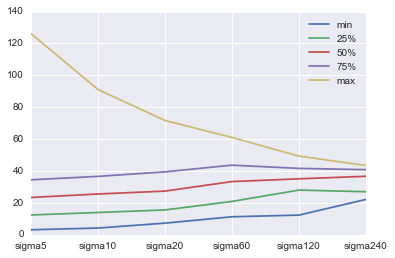

In [80]:
vol_cone_data.plot()

### 1.2 图形对比

In [133]:
#展示起止日期的历史波动率曲线
def sigmaPlot(start='2013-10-21', end='', windows=[5, 10, 20, 50, 100, 200]):
    
    # 数据获取
    data = get_vol_data(start = start, end = end, windows=windows)
    
    plt.figure(figsize=(16,9))
    
    for i in windows:
        data['sigma' + str(i)].plot(label='sigma' + str(i))
        
    plt.legend(loc='best', fontsize='xx-large')
    plt.xticks

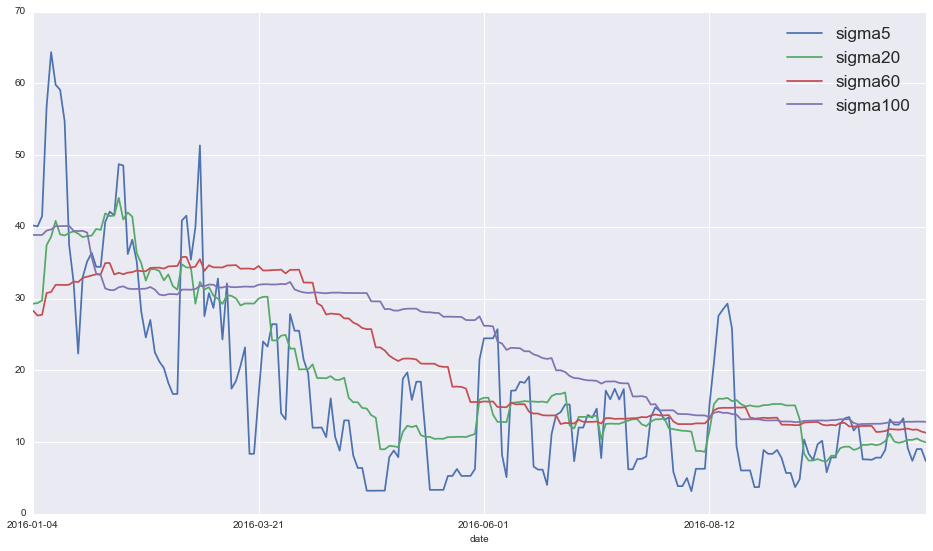

In [134]:
#今年以来的历史波动率

sigmaPlot(start='2016-01-01', windows=[5, 20, 60, 100])

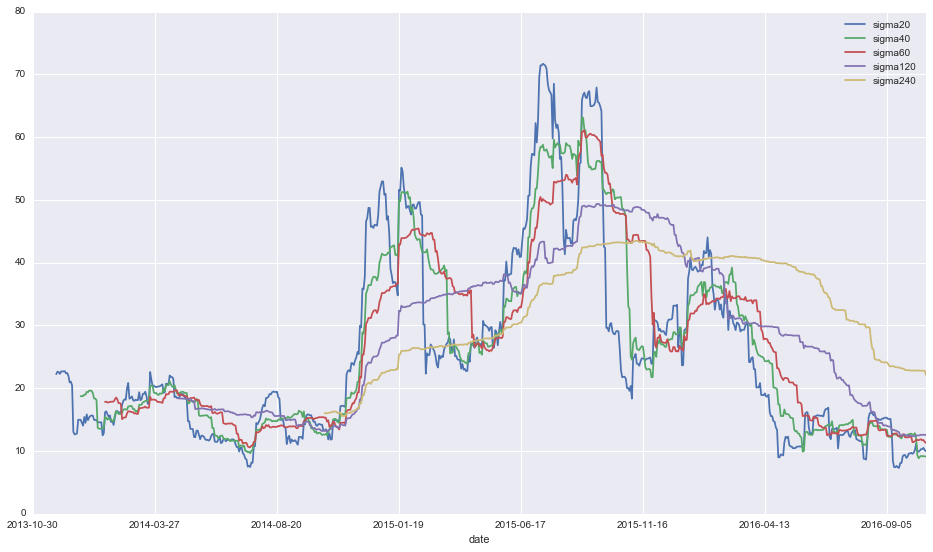

In [47]:
#总的历史波动率
sigmaPlot(windows=[20, 40, 60, 120, 240])

In [62]:
#展示起止日期的历史波动率柱状图
def sigmaHist(start='2013-10-21', end='', windows=[5, 10, 20, 50, 100, 200]):
      
    data = get_vol_data(start = start, end = end, windows = windows)
    
    rows = int(math.ceil(len(windows)/2.0))
    
    fig, axes = plt.subplots(nrows=rows, ncols=2)
    
    #计算sigma
    for k,i in enumerate(windows):
        
        if ((k+1) % 2 == 0):
            ax = axes[k/2 ,1] if rows > 1 else axes[1]
            data['sigma' + str(i)].hist(ax=ax);
            ax.set_title('sigma' + str(i))
        else:
            ax = axes[k/2 ,0] if rows > 1 else axes[0]
            data['sigma' + str(i)].hist(ax=ax);
            ax.set_title('sigma' + str(i))
    
        fig.set_size_inches(fig.get_size_inches()*1.2)
        
    fig.tight_layout()

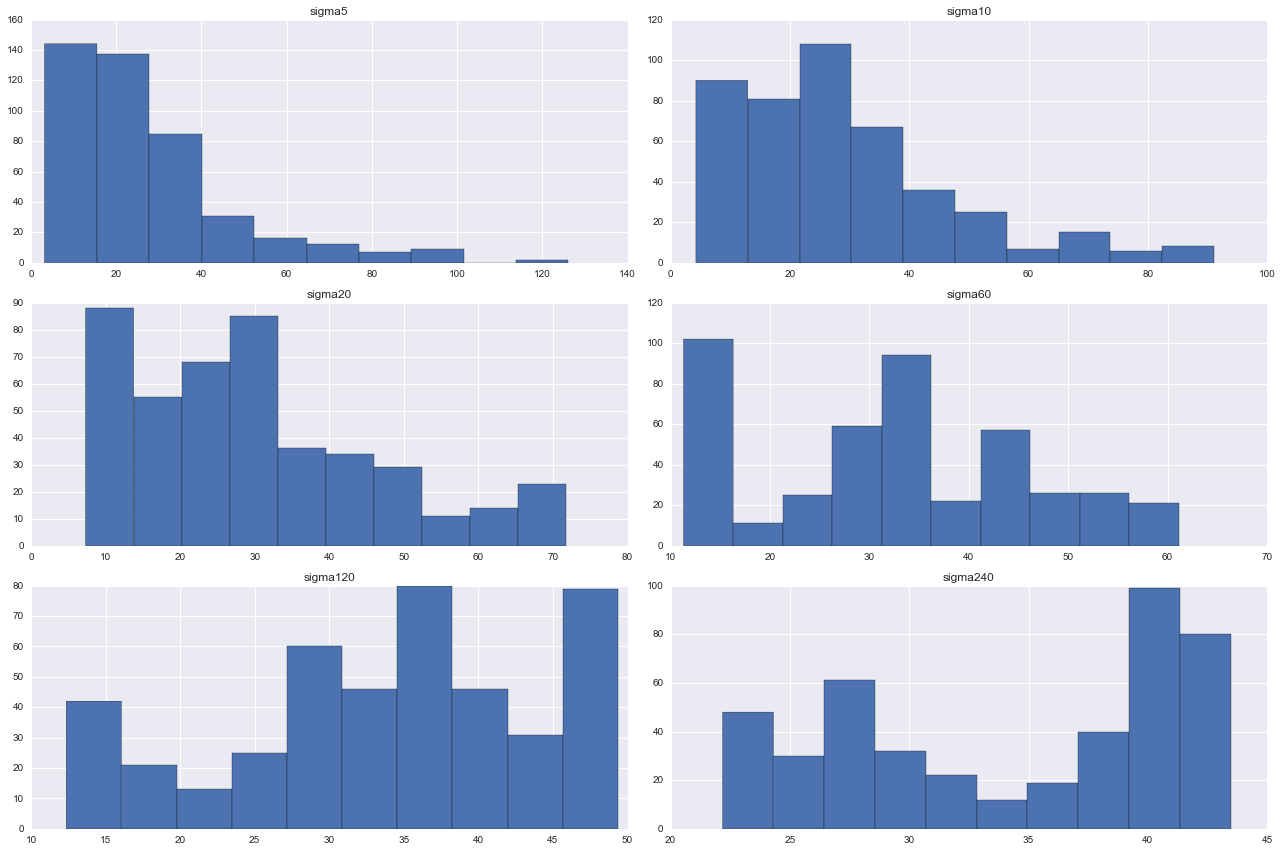

In [63]:
sigmaHist(start='2015-01-01', windows=[5, 10, 20, 60, 120, 240])

## 2. 波动率预测

###  2.1 EWMA法

$$ \sigma^2_n = \lambda \sigma^2_{n-1} + (1 - \lambda)\mu^2_{n-1}  $$

$\lambda$通常取0.9~0.99之间的数值。具体的取值，可以结合历史上的预测效果使用学习算法得出一个恰当的数值出来。

这种方法的有点是简单易用、便于理解，缺点则是不够灵敏，如果某一件事确实是一个异常事件，那么在预测未来波动率时，我们最好将它从数据集中剔除。EWMA法确实可以在波动率预测中平滑价格跳跃的影响，但是其处理方式过于简单。更好的方法是直接让交易员判断一个事件是不是异常时间，如果是的话就直接剔除掉，或者将其视作可能再次发生的特殊时间，并在预测时给予相应的权重。EWMA法假设时间的影响呈指数式递减，其实只是将这一问题简单回避掉了。

使用EWMA方法的另一个问题是它并没有考虑最近的波动率估计量所处的市场环境。无论是通过粗略的观察，还是统计分析都表明：波动率是一个均值回复的过程；高波动率后很可能会出现一段时间的低波动率，反之亦然。

### 2.2 GARCH法

* GARCH(1,1)
 $$ \sigma^2_n = \omega + \alpha \mu^2_{n-1} + \beta \sigma^2_{n-1} $$
 
 $$ \omega = \gamma V_L $$
 
 $$ \gamma + \alpha + \beta = 1  $$ 
 
 $$ V_L = \frac{\omega}{1- \alpha - \beta} $$
 
 
 GARCH模型族，解决了上面所提到的未考虑波动率估计量所处的市场环境的问题。由于模型引入了预期回复的长期平均方差水平项，所以如果当前方差水平处于高位，我们会期待它在短期内维持高位，但最终还是会回归到正常水平。
 
 
 GARCH模型只能得到以指数形式收敛至长期均值的期限结构，但无法得到市场上常见的那种有风的波动率期限结构。比如，2个月期限的波动率比1个月和3个月期限的波动率都要高。这就说明GARCH模型并不适用于期权市场。

### 2.3 波动率锥

“波动率锥的用处是阐明在不同的交易区间内，波动率区间是如何变化的。”

In [135]:

# 展示一定时间内，相应周期的波动率锥曲线
def conePlot(start='', end='', windows=[5, 10, 20, 60, 120, 240]):
    
    vol_data = get_vol_data(start = start, windows = windows)
    
    vol_cone_data = vol_data.describe().T.drop(['count', 'mean', 'std'], axis=1)
    
    fig, ax = plt.subplots(1, 1)
    
    vol_cone_data.plot(ax=ax)
    
    fig.set_size_inches(16, 9)
    
    ax.legend(loc='best', fontsize='xx-large')
    
    fig.tight_layout()
    

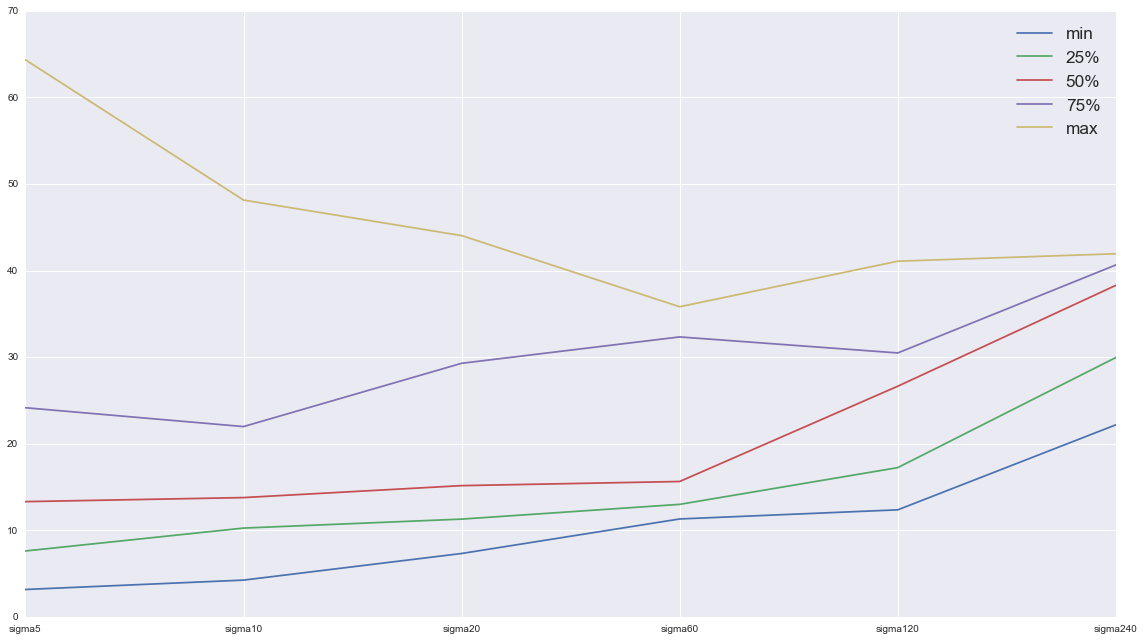

In [137]:
#今年的cone
conePlot(start='2016-01-01')

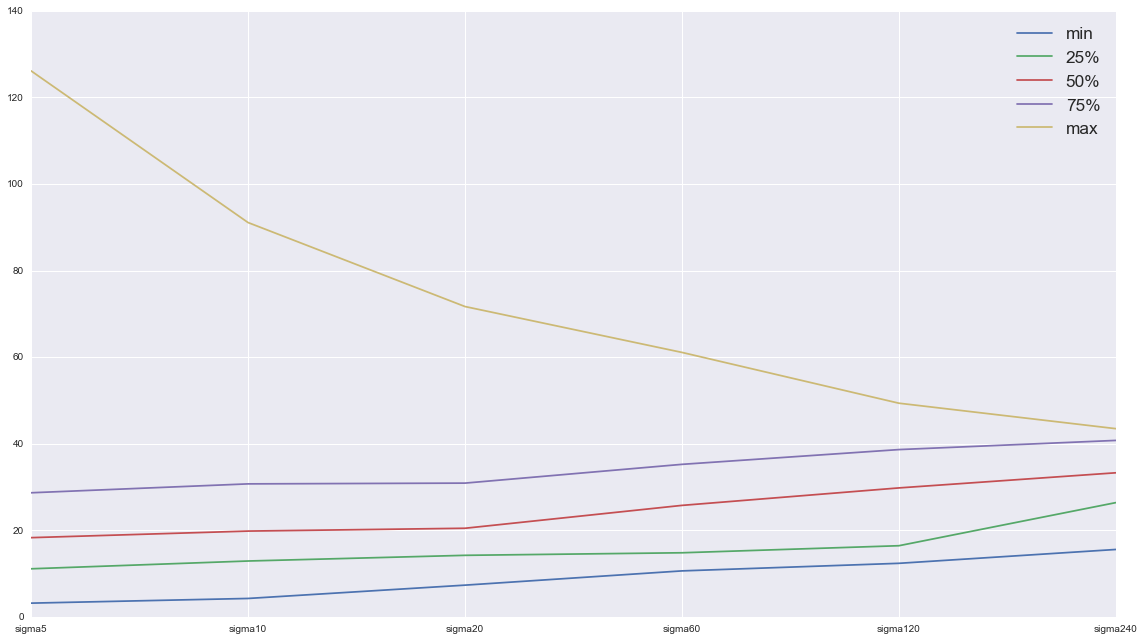

In [136]:
# 上市以来的cone
conePlot()

## 3. 期权波动率研究

## 4. 参考

“波动率锥的用处是阐明在不同的交易区间内，波动率区间是如何变化的。”[^2]


[1]:  Volatility Cones - A Secret Weapon in Options Trading? http://quanttech.co/2014/11/24/volatility-cones-a-secret-weapon-in-options-trading/

[2]: 